In [39]:
import pandas as pd
import glob
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import kpss
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import PredictionErrorDisplay
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dense
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from sklearn.model_selection import train_test_split
# import numpy as np
# import keras_tuner

### LOAD DATA

In [40]:
files = glob.glob(r"C:\projects\ams520\Data\*.csv")#glob the files we are working with

list_of_dfs = [] #instantiate an empty list to append dataframe into it later
for file in files:
    try:
        if "fsi" not in file:
            loc_of_paren = file.split("\\")[-1].find("(") #where the parenthesis is
            indicator = file.split("\\")[-1][:loc_of_paren].strip() #the name of the indicator minus space
            temp = pd.read_csv(file)
            temp.rename(columns = {"Close":indicator},inplace=True) #rename CLose to indicator name
            temp = temp[["Date", indicator]] #Date and indicator column
            temp.Date = pd.to_datetime(temp.Date).dt.date #get date from date time
            temp.set_index("Date",inplace=True) #set it to index
            list_of_dfs.append(temp)
            # list_of_dfs[indicator] = temp #append the values
        else:
            temp = pd.read_csv(file)
            temp['Date'] = pd.to_datetime(temp['Date'])
            temp.set_index("Date", inplace=True)
            # list_of_dfs["FSI"] = temp[["OFR FSI"]]
            list_of_dfs.append(temp[["OFR FSI"]])
    except Exception as e:
        print(e.__str__())
        print(file)

### MERGE AND CLEANUP DATA

In [41]:
#Merge
dfs_level = list_of_dfs[0]
for i in range(1, len(list_of_dfs)):
    # print(list_of_dfs[i].columns)
    dfs_level = dfs_level.merge(list_of_dfs[i], right_index=True, left_index=True, how="inner")

#Convert to float whevern we spot an object data type
for col in dfs_level.columns:
    if str(dfs_level[col].dtype) == "object":
        dfs_level[col] = dfs_level[col].str.replace(",","")
        dfs_level[col] = dfs_level[col].astype("float")

dfs_level.columns = [x.replace("Data/","").replace(".cs","") for x in dfs_level.columns]

## Differenced Model

In [42]:
dfs = dfs_level / dfs_level.shift(1) -1 #PERCENT CHANGE FOR EVERYTHING ELSE
dfs['OFR FSI'] = dfs_level['OFR FSI'].diff(1) #FSI REVOLVES AROUND 0 THERE A SIMPLE DIFF IS APPROPRIATE

### LETS VISUALIZE THE DATA

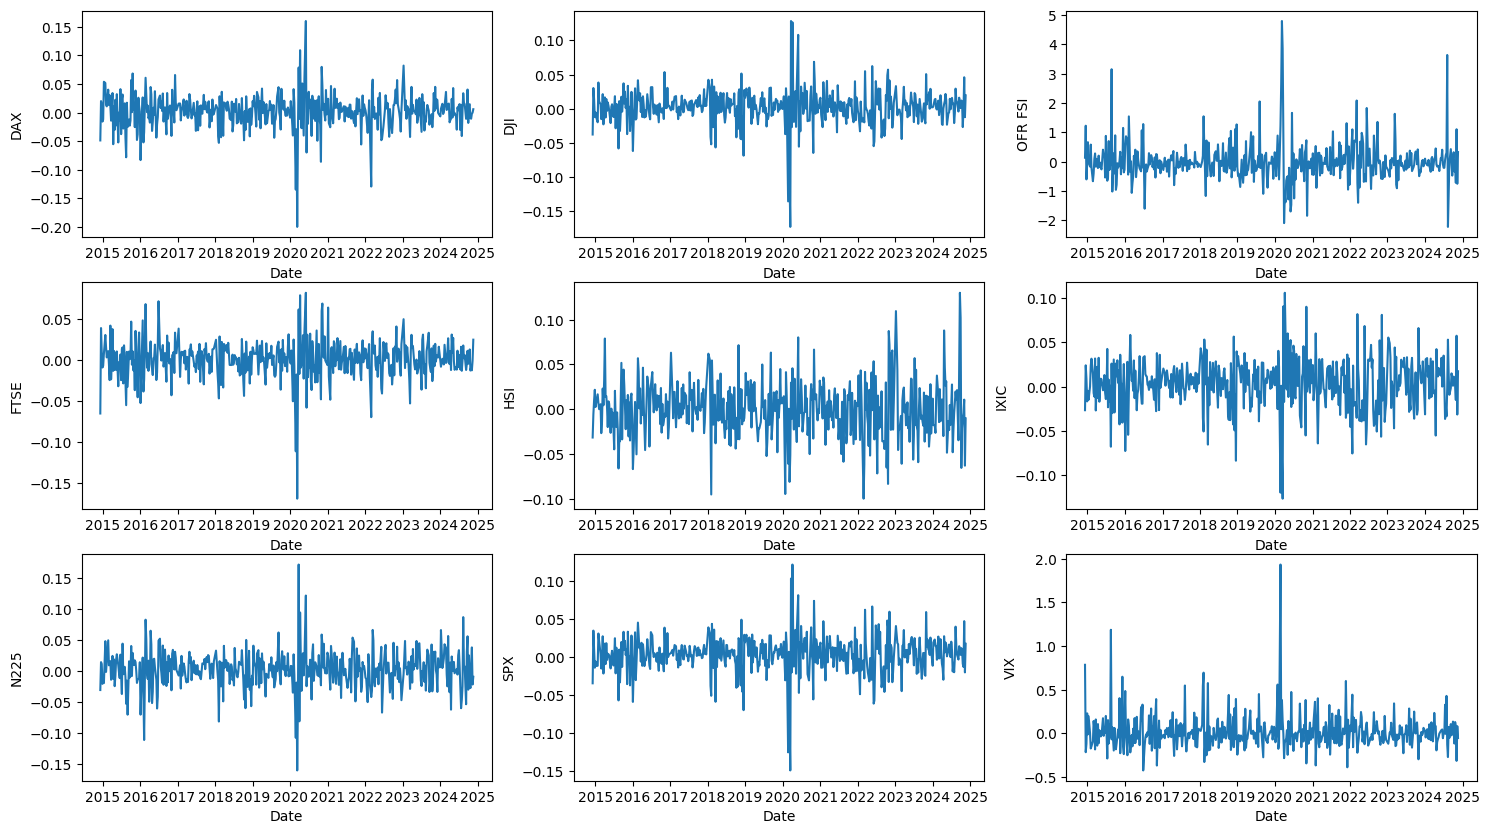

In [43]:
fig, axes = plt.subplots(nrows = 3, ncols=3,figsize=(18, 10))
i  = 0; j=0
for col in dfs_level.columns:
    sns.lineplot(ax=axes[i, j], x = dfs.index, y=dfs[col])
    j+=1
    if j > 2:
        j = 0
        i+=1
    else:
        pass

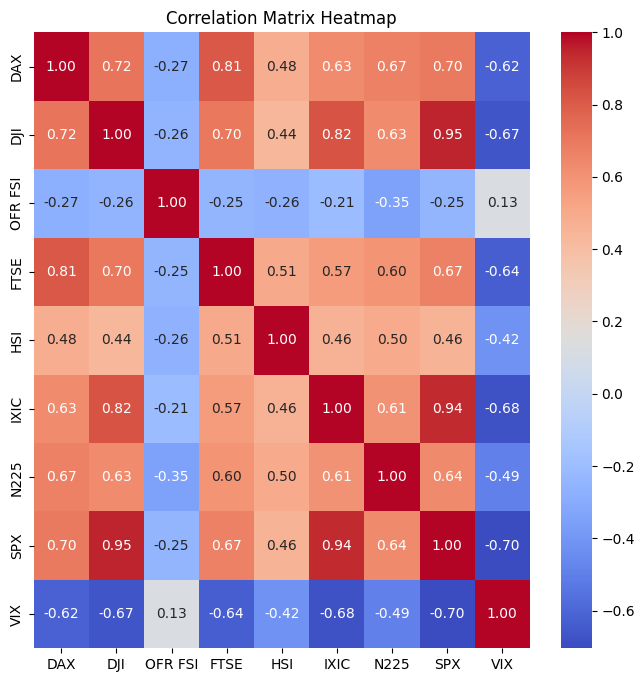

In [6]:
plt.figure(figsize=(8, 8))
sns.heatmap(dfs.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

<Axes: title={'center': 'FSI DIFF'}, xlabel='Date'>

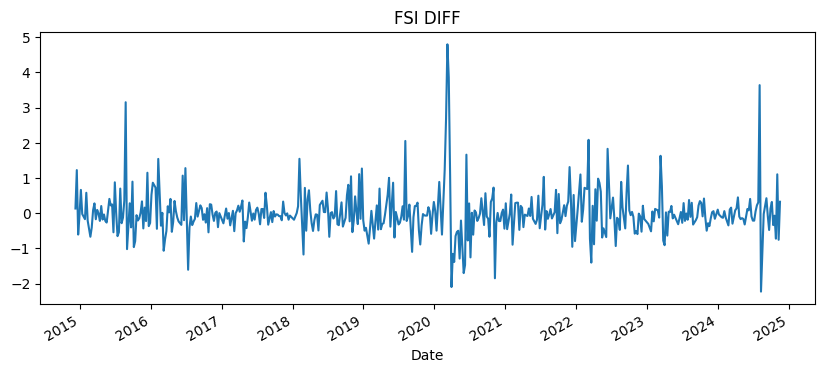

In [7]:
dfs["OFR FSI"].plot(figsize=(10,4),title="FSI DIFF")

## MODELLING
### Performance metric: MSE
### Test/Train Split
 - Training the models on data upto and including 2022-12-12 ~ 81%
 - Test will on data from 2023-01-09 to 2024-11-18

### Linear Regression - Benchmark Model

In [44]:
comparison_df = dfs[['OFR FSI']]

In [45]:
y_train, x_train = dfs.loc[:"2023-01-01", ['OFR FSI']].dropna(), dfs.loc[:"2023-01-01"].drop(columns = ['OFR FSI']).dropna()
y_test,  x_test  = dfs.loc["2023-01-01":, ['OFR FSI']], dfs.loc["2023-01-01":].drop(columns = ['OFR FSI'])

In [46]:
lr_model = LinearRegression() #Instantiate the model
lr_model.fit(x_train.values, y_train.values) #fit and train the model
in_sample_prediction = lr_model.predict(x_train.values)
in_sample_prediction = pd.Series([x[0] for x in in_sample_prediction], index = y_train.index)
out_sample_prediction = lr_model.predict(x_test.values)
out_sample_prediction = pd.Series([x[0] for x in out_sample_prediction], index = y_test.index)
cor_coef =  np.corrcoef(y_test["OFR FSI"], out_sample_prediction)[0,1] ##correlation coefficient
print("In  sample score R^2  : ", lr_model.score(x_train.values,y_train.values) )
print("Out sample Correlation: ", cor_coef )
print("Out sample MSE        : ", mean_squared_error(y_test.values, out_sample_prediction.values) )
#Save starting from the second row
comparison_df.loc["2014-12-08":,'LR_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)

In  sample score R^2  :  0.16206059187875088
Out sample Correlation:  0.24556320731326217
Out sample MSE        :  0.3469562483901471


C:\Users\sahil\AppData\Local\Temp\ipykernel_11000\3983870764.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df.loc["2014-12-08":,'LR_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)


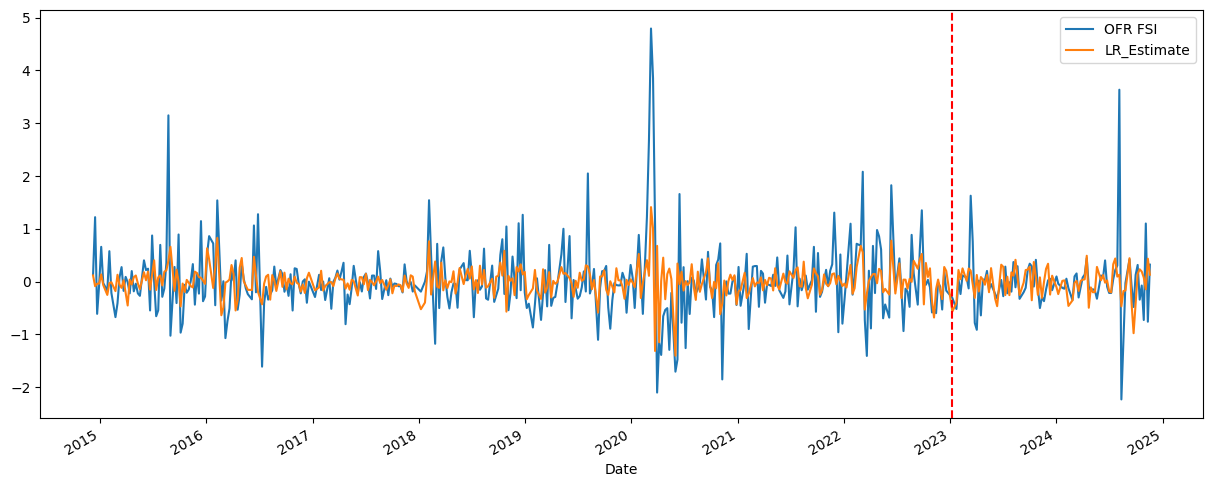

In [47]:
comparison_df[['OFR FSI', 'LR_Estimate']].plot(figsize = (15,6)).axvline(x="2023-01-09", color='red', linestyle='--')

### Light GBM

In [48]:
lgm_model = LGBMRegressor() #Instantiate the model
lgm_model.fit(x_train,y_train) #fit and train the model
in_sample_prediction = lgm_model.predict(x_train)
in_sample_prediction = pd.Series([x for x in in_sample_prediction], index = y_train.index)
out_sample_prediction = lgm_model.predict(x_test)
out_sample_prediction = pd.Series([x for x in out_sample_prediction], index = y_test.index)
cor_coef =  np.corrcoef(y_test["OFR FSI"], out_sample_prediction)[0,1] ##correlation coefficient

print("In  sample score R^2  : ", lgm_model.score(x_train.values, y_train.values) )
print("Out sample Correlation: ", cor_coef )
print("Out sample MSE        : ", mean_squared_error(y_test.values, out_sample_prediction.values) )
comparison_df.loc["2014-12-08":,'LGBM_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)

In  sample score R^2  :  0.7521144476293234
Out sample Correlation:  0.031068748695616443
Out sample MSE        :  0.49082750647068657


C:\Users\sahil\AppData\Local\Temp\ipykernel_11000\3652627204.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df.loc["2014-12-08":,'LGBM_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)


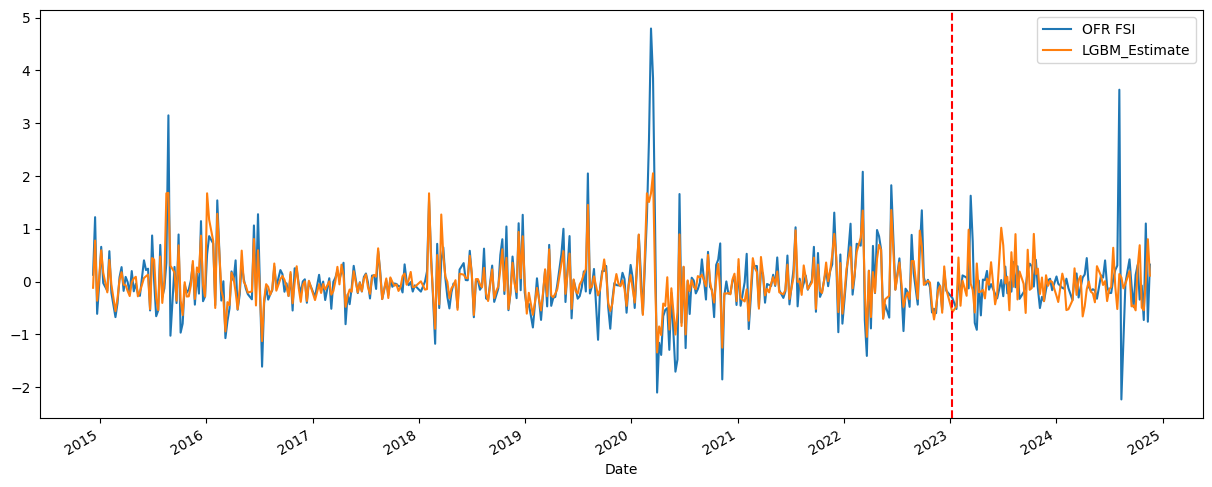

In [49]:
comparison_df[['OFR FSI', 'LGBM_Estimate']].plot(figsize = (15,6)).axvline(x="2023-01-09", color='red', linestyle='--')

## Random Forrest

In [50]:
rf_model = RandomForestRegressor() #Instantiate the model
rf_model.fit(x_train.values, y_train.values.ravel()) #fit and train the model
in_sample_prediction = rf_model.predict(x_train.values)
in_sample_prediction = pd.Series([x for x in in_sample_prediction], index = y_train.index)
out_sample_prediction = rf_model.predict(x_test.values)
out_sample_prediction = pd.Series([x for x in out_sample_prediction], index = y_test.index)
cor_coef =  np.corrcoef(y_test["OFR FSI"], out_sample_prediction)[0,1] ##correlation coefficient

print("In  sample score R^2  : ", rf_model.score(x_train.values, y_train.values.ravel()) )
print("Out sample Correlation: ", cor_coef )
print("Out sample MSE        : ", mean_squared_error(y_test.values.ravel(), out_sample_prediction.values.ravel()) )
comparison_df.loc["2014-12-08":,'RF_Estimate'] = pd.concat([in_sample_prediction, out_sample_prediction], axis=0)

In  sample score R^2  :  0.8679898496690348
Out sample Correlation:  0.20034109812817824
Out sample MSE        :  0.35759897090277454


C:\Users\sahil\AppData\Local\Temp\ipykernel_11000\93322725.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df.loc["2014-12-08":,'RF_Estimate'] = pd.concat([in_sample_prediction, out_sample_prediction], axis=0)


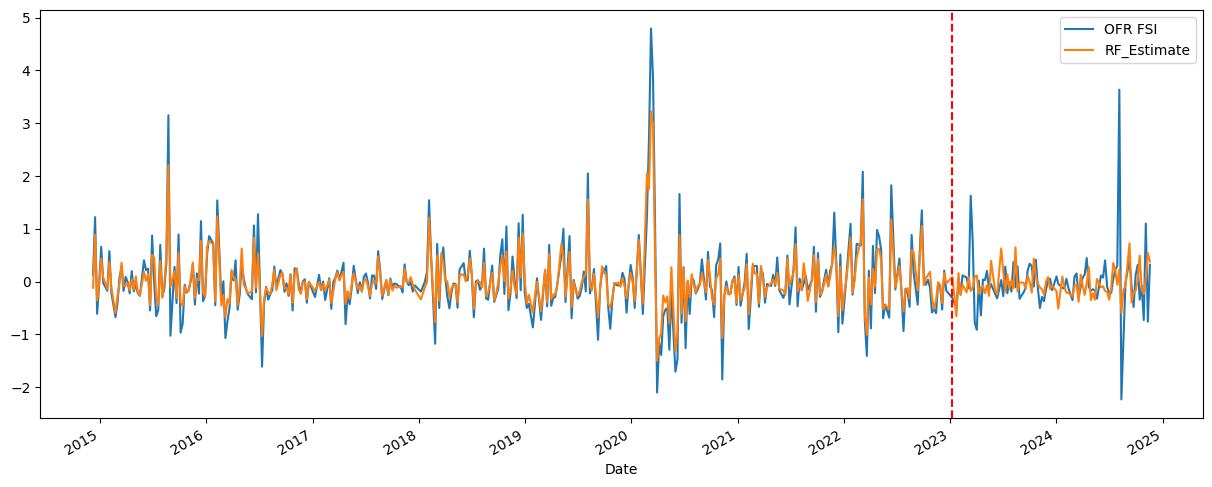

In [51]:
comparison_df[['OFR FSI', 'RF_Estimate']].plot(figsize = (15,6)).axvline(x="2023-01-09", color='red', linestyle='--')

### Polynomial Regression

In [52]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features_train = poly.fit_transform(x_train.values)
poly_features_test = poly.fit_transform(x_test.values)

poly_model = LinearRegression() #Instantiate the model
poly_model.fit(poly_features_train, y_train.values) #fit and train the model
in_sample_prediction = poly_model.predict(poly_features_train)
in_sample_prediction = pd.Series([x[0] for x in in_sample_prediction], index = y_train.index)

out_sample_prediction = poly_model.predict(poly_features_test)
out_sample_prediction = pd.Series([x[0] for x in out_sample_prediction], index = y_test.index)
cor_coef =  np.corrcoef(y_test["OFR FSI"], out_sample_prediction)[0,1] ##correlation coefficient

print("In  sample score R^2  : ", poly_model.score(poly_features_train, y_train.values) )
print("Out sample Correlation: ", cor_coef )
print("Out sample MSE        : ", mean_squared_error(y_test.values, out_sample_prediction.values) )
comparison_df.loc[:,'Poly_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)

In  sample score R^2  :  0.43531676418712517
Out sample Correlation:  0.10145654693581498
Out sample MSE        :  0.47989947547258943


C:\Users\sahil\AppData\Local\Temp\ipykernel_11000\2289439931.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df.loc[:,'Poly_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)


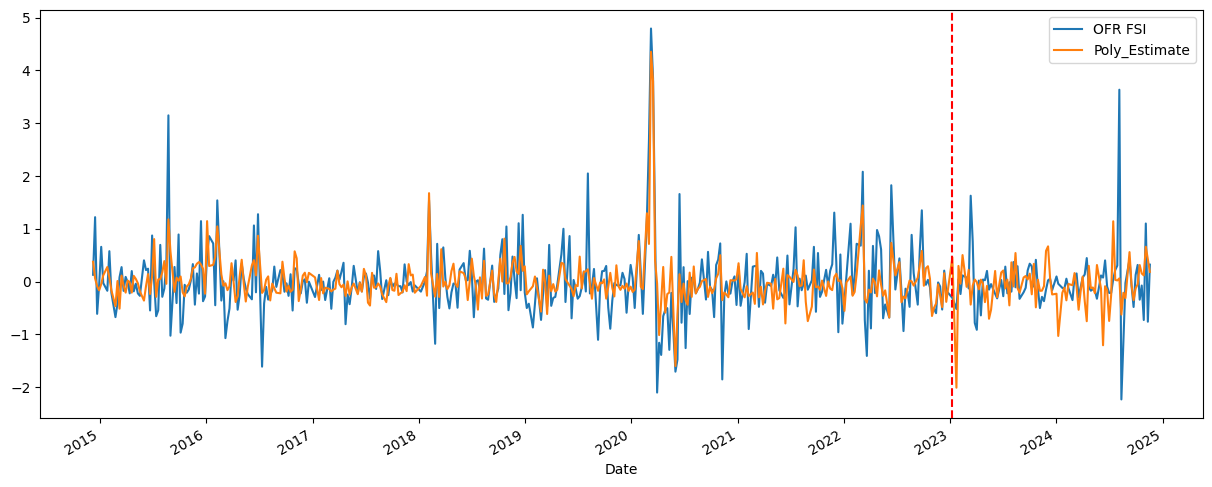

In [53]:
comparison_df[['OFR FSI', 'Poly_Estimate']].plot(figsize = (15,6)).axvline(x="2023-01-09", color='red', linestyle='--')

### AR-X Model

In [54]:
## Arrange Train
arx_train_data = pd.concat([y_train, y_train.shift(1).rename(columns = {"OFR FSI": "OFR FSI Lag"}), x_train.shift(1)], axis=1)
arx_train_data = arx_train_data.dropna()
arx_y_train, arx_x_train = arx_train_data[['OFR FSI']], arx_train_data.drop(columns = ['OFR FSI'])

##Arrange Test
arx_test_data = pd.concat([y_test, y_test.shift(1).rename(columns = {"OFR FSI": "OFR FSI Lag"}), x_test.shift(1)], axis=1)
arx_test_data.iloc[0,1:] = y_train.tail(1).values.tolist()[0] + x_train.tail(1).values.tolist()[0] #Borrow from previous row because lag1
arx_y_test, arx_x_test = arx_test_data[['OFR FSI']], arx_test_data.drop(columns = ['OFR FSI'])

arx_model = LinearRegression() #Instantiate the model
arx_model.fit(arx_x_train, arx_y_train) #fit and train the model
in_sample_prediction = arx_model.predict(arx_x_train)
in_sample_prediction = pd.Series([x[0] for x in in_sample_prediction], index = arx_y_train.index)

out_sample_prediction = arx_model.predict(arx_x_test)
out_sample_prediction = pd.Series([x[0] for x in out_sample_prediction], index = arx_y_test.index)
cor_coef =  np.corrcoef(arx_y_test["OFR FSI"], out_sample_prediction)[0,1] ##correlation coefficient

print("In  sample score R^2  : ", arx_model.score(arx_x_train, arx_y_train) )
print("Out sample Correlation: ", cor_coef )
print("Out sample MSE        : ", mean_squared_error(arx_y_test, out_sample_prediction) )
comparison_df.loc[:,'ARX_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)

In  sample score R^2  :  0.5440813751316522
Out sample Correlation:  0.5845298472943105
Out sample MSE        :  0.23357814870667176


C:\Users\sahil\AppData\Local\Temp\ipykernel_11000\989682721.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df.loc[:,'ARX_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)


In [55]:
feature_importances = pd.DataFrame({'Feature': arx_x_train.columns.tolist(), 'Importance': arx_model.coef_.tolist()[0]})
print(feature_importances)

       Feature  Importance
0  OFR FSI Lag   -0.006758
1          DAX   -8.038191
2          DJI   -1.361558
3         FTSE   -3.239826
4          HSI    1.841433
5         IXIC   -6.591023
6         N225    0.867152
7          SPX    3.832259
8          VIX    0.841046


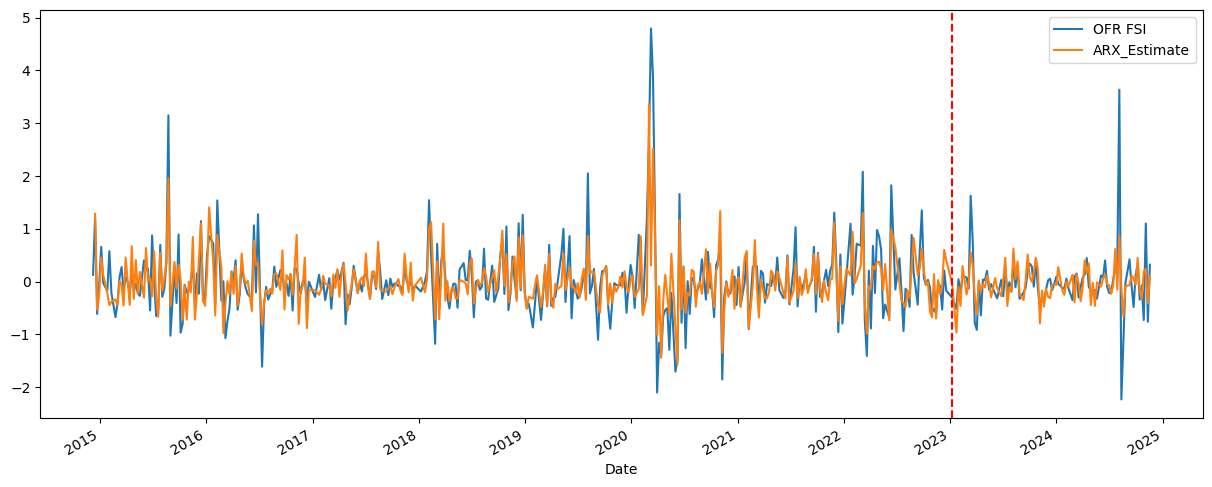

In [56]:
comparison_df[['OFR FSI', 'ARX_Estimate']].plot(figsize = (15,6)).axvline(x="2023-01-09", color='red', linestyle='--')

### MLPRegressor

In [57]:
mlp_model = MLPRegressor(hidden_layer_sizes=(20),  
                         solver='lbfgs', # Solver basically tells us how the weights will change during backpropagation
                         activation='relu',    
                         random_state=42)
mlp_model.fit(x_train, y_train.values.ravel())
# Train the model
in_sample_prediction = mlp_model.predict(x_train)
in_sample_prediction = pd.Series([x for x in in_sample_prediction], index = y_train.index)
out_sample_prediction = mlp_model.predict(x_test)
out_sample_prediction = pd.Series([x for x in out_sample_prediction], index = y_test.index)
cor_coef =  np.corrcoef(y_test["OFR FSI"], out_sample_prediction)[0,1] ##correlation coefficient

print("In  sample score R^2  : ", mlp_model.score(x_train, y_train) )
print("Out sample Correlation: ", cor_coef )
print("Out sample MSE        : ", mean_squared_error(y_test, out_sample_prediction) )
comparison_df.loc[:,'MLP_Estimate'] = pd.concat([in_sample_prediction, out_sample_prediction], axis=0)

In  sample score R^2  :  0.3111241766796228
Out sample Correlation:  0.18033418347423646
Out sample MSE        :  0.34831921110188074


C:\Users\sahil\AppData\Local\Temp\ipykernel_11000\4017260683.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df.loc[:,'MLP_Estimate'] = pd.concat([in_sample_prediction, out_sample_prediction], axis=0)


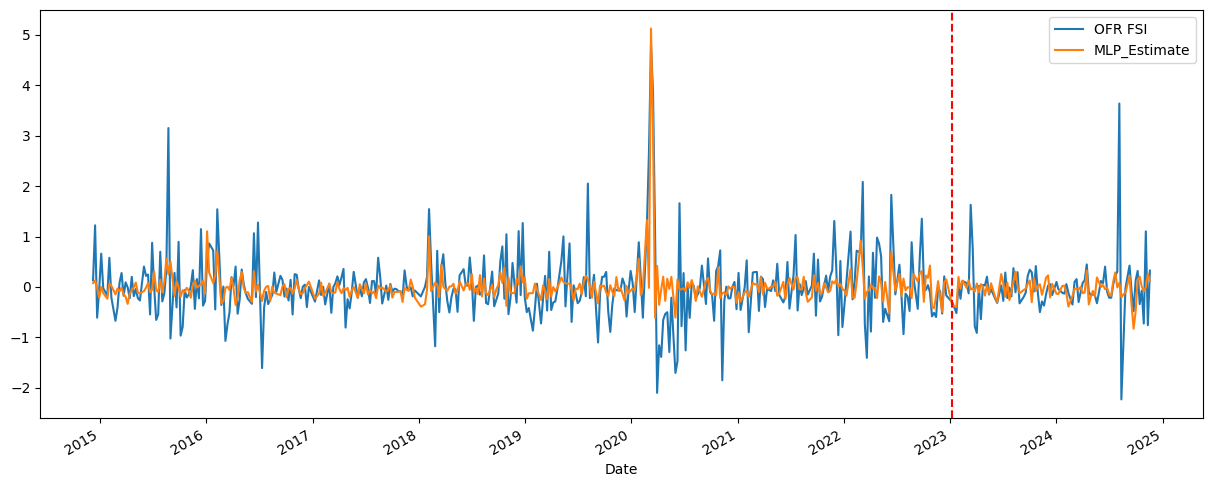

In [58]:
comparison_df[['OFR FSI', 'MLP_Estimate']].plot(figsize = (15,6)).axvline(x="2023-01-09", color='red', linestyle='--')

## Residual Analysis

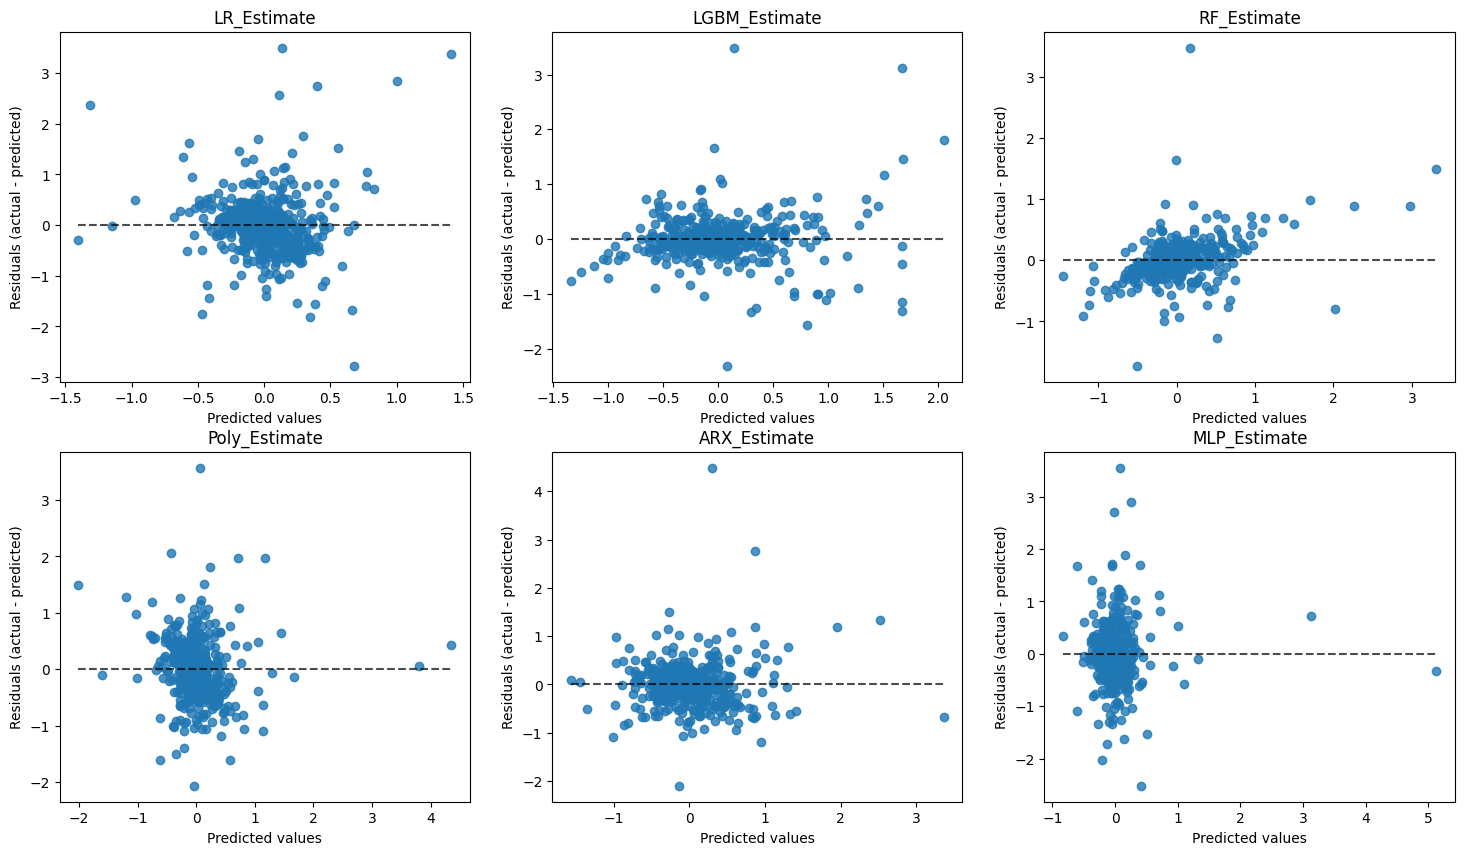

In [23]:
fig, axes = plt.subplots(nrows = 2, ncols=3,figsize=(18, 10))
i  = 0; j=0
for col in comparison_df.columns:
    if col != 'OFR FSI':
        display = PredictionErrorDisplay(y_true=comparison_df['OFR FSI'], y_pred=comparison_df[col])
        axes[i, j].set_title(col)
        display.plot(ax=axes[i, j])    
        j+=1
        if j > 2:
            j = 0
            i+=1
        else:
            pass

## Correlation matrix on stationary data

In [24]:
comparison_df.loc["2023-01-09":].corr()

,OFR FSI,LR_Estimate,LGBM_Estimate,RF_Estimate,Poly_Estimate,ARX_Estimate,MLP_Estimate
OFR FSI,1.000000,0.245563,0.031069,0.232939,0.101457,0.584530,0.180334
LR_Estimate,0.245563,1.000000,0.530860,0.627377,0.371090,0.107567,0.924461
LGBM_Estimate,0.031069,0.530860,1.000000,0.733296,0.367403,0.046774,0.584631
RF_Estimate,0.232939,0.627377,0.733296,1.000000,0.547323,0.160512,0.641489
Poly_Estimate,0.101457,0.371090,0.367403,0.547323,1.000000,0.112495,0.388343
ARX_Estimate,0.584530,0.107567,0.046774,0.160512,0.112495,1.000000,0.105117
MLP_Estimate,0.180334,0.924461,0.584631,0.641489,0.388343,0.105117,1.000000


## Correlation plot after bringing it back to levels/non-stationary

In [25]:
comparison_df_level = comparison_df.add(dfs_level['OFR FSI'].shift(1),axis=0)
# comparison_df_level['ARX_Estimate'] = comparison_df['ARX_Estimate'] + dfs_level['OFR FSI'].shift(2)
comparison_df_level.loc["2023-01-09":].corr()

,OFR FSI,LR_Estimate,LGBM_Estimate,RF_Estimate,Poly_Estimate,ARX_Estimate,MLP_Estimate
OFR FSI,1.000000,0.815159,0.768195,0.819498,0.760622,0.875220,0.816623
LR_Estimate,0.815159,1.000000,0.950361,0.974147,0.918923,0.918729,0.992668
LGBM_Estimate,0.768195,0.950361,1.000000,0.969201,0.906338,0.889739,0.955402
RF_Estimate,0.819498,0.974147,0.969201,1.000000,0.939845,0.930136,0.981161
Poly_Estimate,0.760622,0.918923,0.906338,0.939845,1.000000,0.878539,0.926507
ARX_Estimate,0.875220,0.918729,0.889739,0.930136,0.878539,1.000000,0.936027
MLP_Estimate,0.816623,0.992668,0.955402,0.981161,0.926507,0.936027,1.000000


## Plotting all the models together on levels

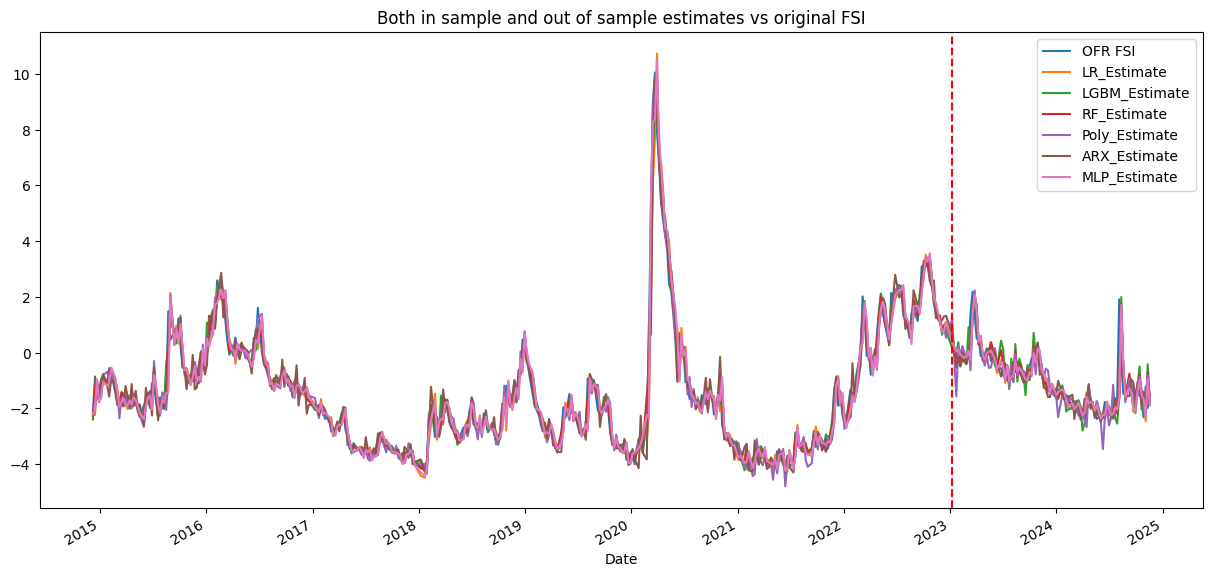

In [26]:
ax = comparison_df_level.plot(figsize=(15,7),title="Both in sample and out of sample estimates vs original FSI")
ax.axvline(x="2023-01-09", color='red', linestyle='--')

<Axes: title={'center': 'Out of sample estimates vs original FSI'}, xlabel='Date'>

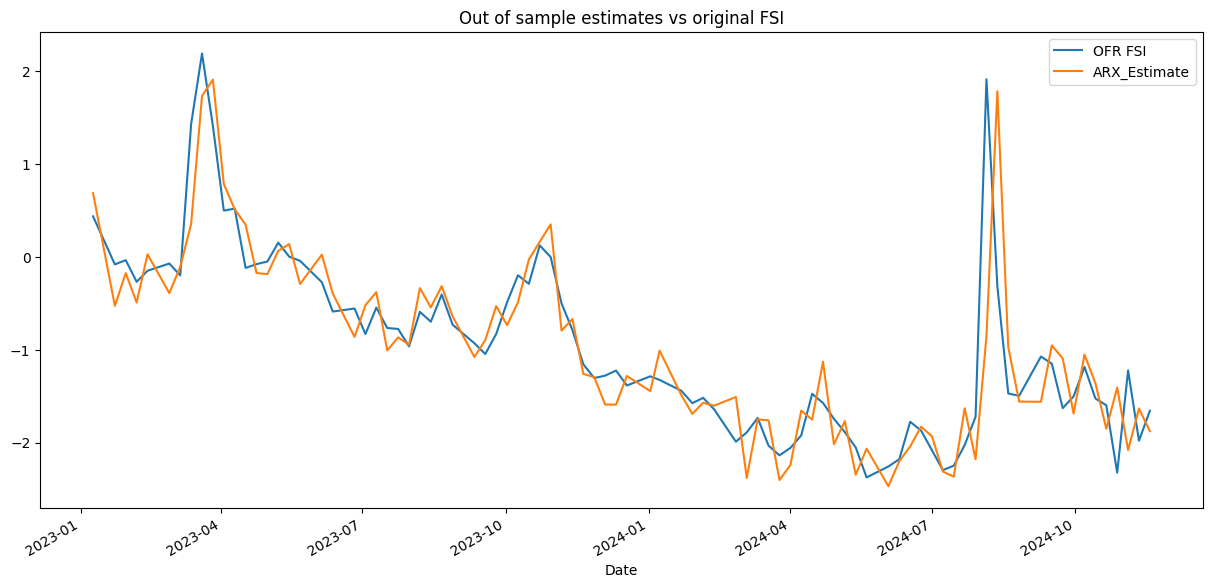

In [27]:
comparison_df_level.loc["2023-01-09":, ['OFR FSI','ARX_Estimate']].plot(figsize=(15,7),title="Out of sample estimates vs original FSI")

## Dynamic modelling with AR-X Implementation on all models
Where we rolled our models as we observed newer data

In [28]:
dfs_reindex = dfs.reset_index()
# dfs_reindex.iloc[[379],1:] #Example of last row for prediction

In [29]:
lr_rolling_results = []
lr_rolling_lgbm = []
lr_rolling_rf = []
lr_rolling_poly = []
LR_MODEL = []
temp_qr_predict = None

for i in range(380, 468):
    
    print("Y_range", i-379, "to", i-1, "predict at ", i)
    print("X_range", i-380, "to", i-2, "predict at ", i)

    #For Training
    Y = dfs_reindex.iloc[i-379 : i, 3]
    X = dfs_reindex.iloc[i-380 : i-1,1:]
    print("Shapes: ", "Y:", Y.shape, "X:",X.shape) 
    #For prediction
    lagged_independent = dfs_reindex.iloc[[i-1], 1:]

    #Instantiate the model 
    arx_model_loop = LinearRegression() #Instantiate the model
    rf_model = RandomForestRegressor(verbose=0) #Instantiate the model
    lgm_model = LGBMRegressor(verbose=-1) #Instantiate the model
    
    if i == 380:
        #Need to make adjustment when i==380 becuase we have NaN on the first row due to differencing 
        X = X.dropna()
        Y = Y.iloc[1:]
        print(Y.head())
        print(Y.tail())
        print(X.head())
        print(X.tail())
        print(lagged_independent.T)
        print("Shapes: ", "Y:", Y.shape, "X:",X.shape)
    
    #Linear Regression with AR-X framework
    arx_model_loop.fit(X.dropna(), Y.dropna()) #fit and train the model
    rf_model.fit(X.dropna(), Y.dropna()) #fit and train the model
    lgm_model.fit(X.dropna(), Y.dropna()) #fit and train the model
    
    out_sample_prediction = arx_model_loop.predict(lagged_independent)
    out_sample_prediction_rf = rf_model.predict(lagged_independent)
    out_sample_prediction_lgbm = lgm_model.predict(lagged_independent)
    
    LR_MODEL.append(arx_model_loop) #Save the model for evaluatin later        
    lr_rolling_results.append(out_sample_prediction[0])
    lr_rolling_lgbm.append(out_sample_prediction_lgbm[0])
    lr_rolling_rf.append(out_sample_prediction_rf[0])

Y_range 1 to 379 predict at  380
X_range 0 to 378 predict at  380
Shapes:  Y: (379,) X: (379, 9)
2    1.222
3   -0.609
4   -0.055
5    0.660
6   -0.026
Name: OFR FSI, dtype: float64
375   -0.014306
376   -0.091514
377   -0.527301
378    0.209343
379   -0.169031
Name: OFR FSI, dtype: float64
        DAX       DJI  OFR FSI      FTSE       HSI      IXIC      N225  \
1 -0.048802 -0.037753    0.131 -0.065582 -0.031413 -0.026598 -0.030580   
2  0.020035  0.030322    1.222  0.038828 -0.005678  0.024020  0.014333   
3  0.013809  0.013985   -0.609  0.009879  0.010036  0.008704  0.011237   
4 -0.015862 -0.012241   -0.055 -0.009399  0.021800 -0.016653 -0.020652   
5 -0.011903 -0.005383    0.660 -0.007126  0.002599 -0.004811 -0.014498   

        SPX       VIX  
1 -0.035194  0.783418  
2  0.034120 -0.217742  
3  0.008751 -0.120679  
4 -0.014635  0.226897  
5 -0.006506 -0.013491  
          DAX       DJI   OFR FSI      FTSE       HSI      IXIC      N225  \
374  0.014552 -0.000059 -0.596431  0.00922

In [30]:
temp = pd.concat([
    pd.Series(lr_rolling_results, index=y_test.index, name="Linear AR-X"),
    pd.Series(lr_rolling_lgbm, index=y_test.index, name="LightGBM AR-X"),
    pd.Series(lr_rolling_rf, index=y_test.index, name="RF AR-X"),
    y_test], axis=1)

## Residual Analysis on rolling window
You're not really supposed to do residual analysis on rolling window since each error is basically calculated with a different model, so its not very accurate to perform any kind of residual analysis on it.

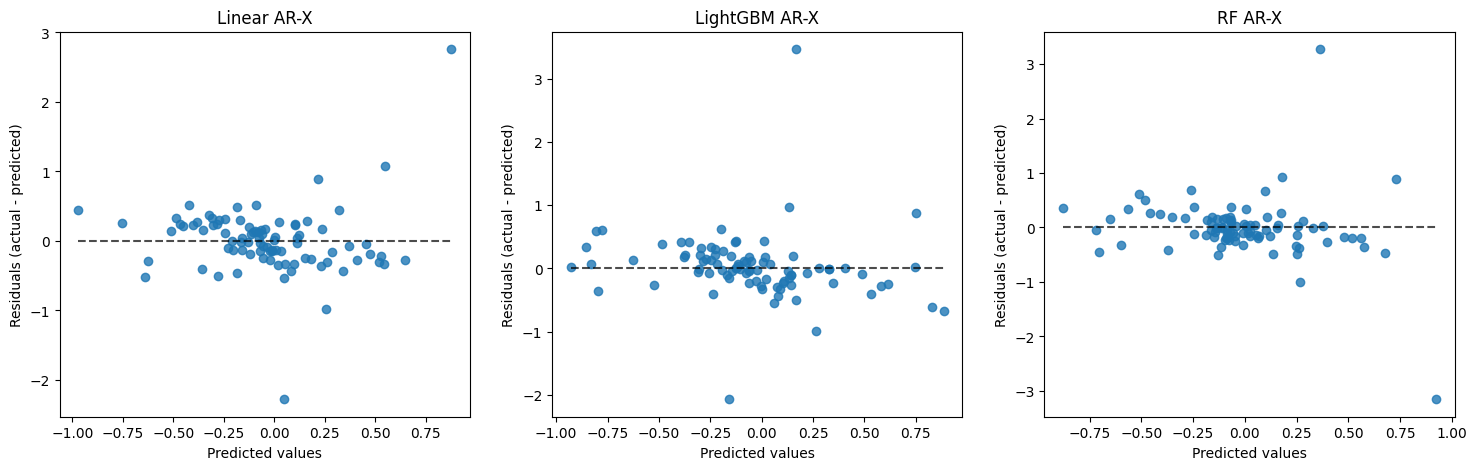

In [31]:
fig, axes = plt.subplots(nrows = 1, ncols=3,figsize=(18, 5))
i  = 0; j=0
for col in temp.columns:
    if col != 'OFR FSI':
        display = PredictionErrorDisplay(y_true=temp['OFR FSI'], y_pred=temp[col])
        axes[j].set_title(col)
        display.plot(ax=axes[j])    
        j+=1
        if j > 2:
            j = 0
            i+=1
        else:
            pass

In [32]:
temp.corr()

,Linear AR-X,LightGBM AR-X,RF AR-X,OFR FSI
Linear AR-X,1.000000,0.814018,0.847441,0.552734
LightGBM AR-X,0.814018,1.000000,0.847351,0.461886
RF AR-X,0.847441,0.847351,1.000000,0.334023
OFR FSI,0.552734,0.461886,0.334023,1.000000


<Axes: title={'center': 'Out of sample in transformed data'}, xlabel='Date'>

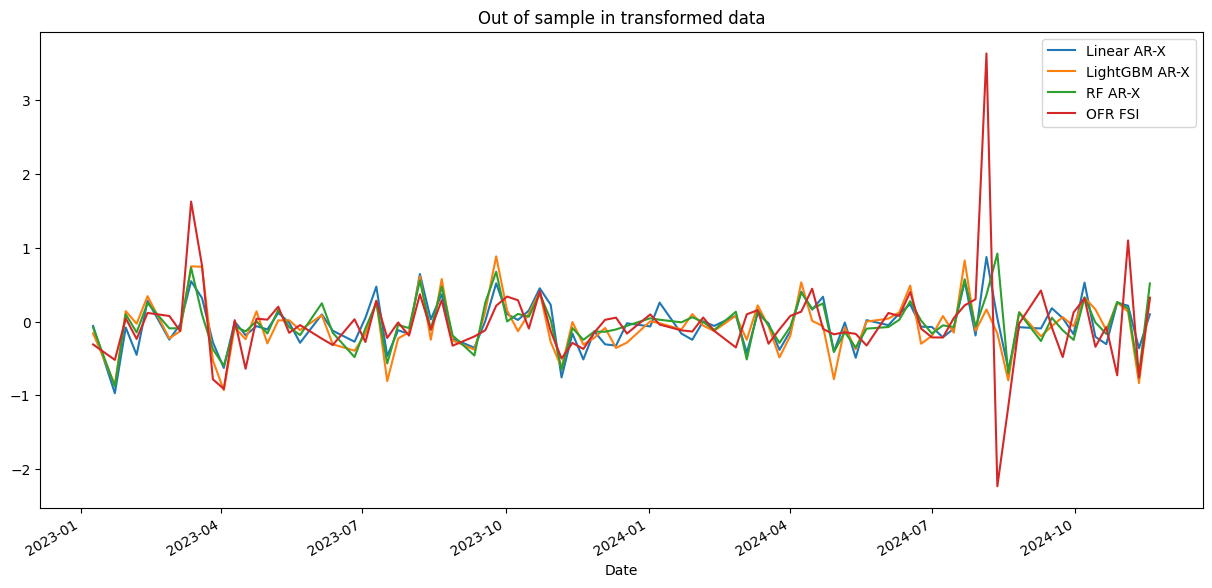

In [33]:
temp.plot(figsize=(15,7), title="Out of sample in transformed data")

## Bringing all of our rolling data back to levels

In [34]:
roll_levels = temp.add(dfs_level["2022-12-19":].shift(1).loc["2023-01-09":,'OFR FSI'],axis=0)

In [35]:
roll_levels.corr()

,Linear AR-X,LightGBM AR-X,RF AR-X,OFR FSI
Linear AR-X,1.000000,0.976639,0.984559,0.869946
LightGBM AR-X,0.976639,1.000000,0.981412,0.848234
RF AR-X,0.984559,0.981412,1.000000,0.830634
OFR FSI,0.869946,0.848234,0.830634,1.000000


<Axes: title={'center': 'Out of sample in levels'}, xlabel='Date'>

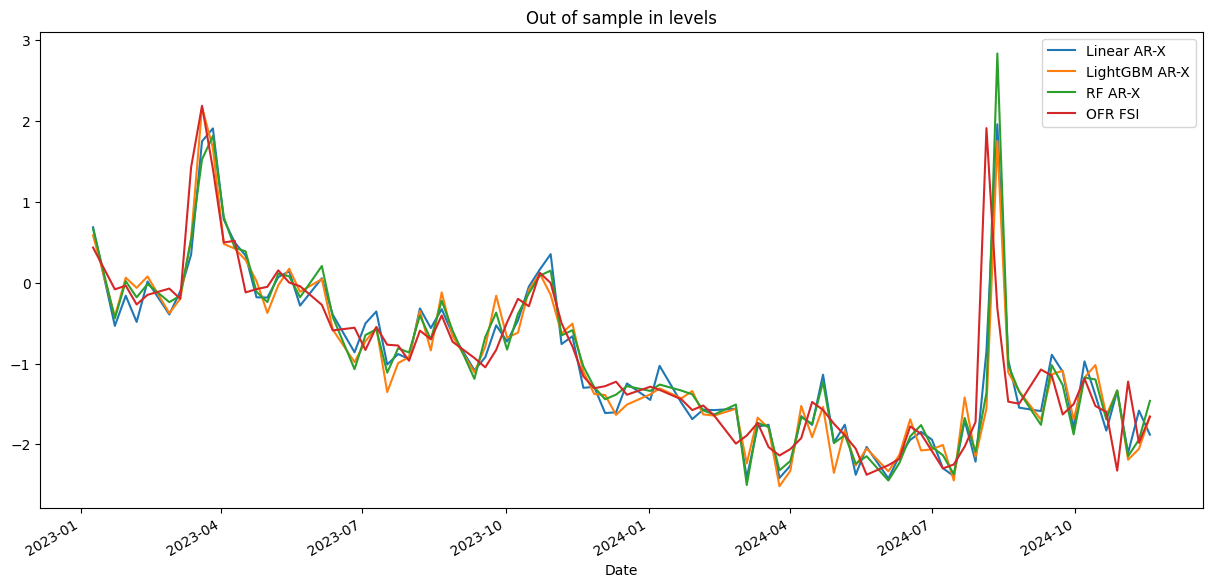

In [36]:
roll_levels.plot(figsize=(15,7), title="Out of sample in levels")

<Axes: title={'center': 'Out of sample in levels'}, xlabel='Date'>

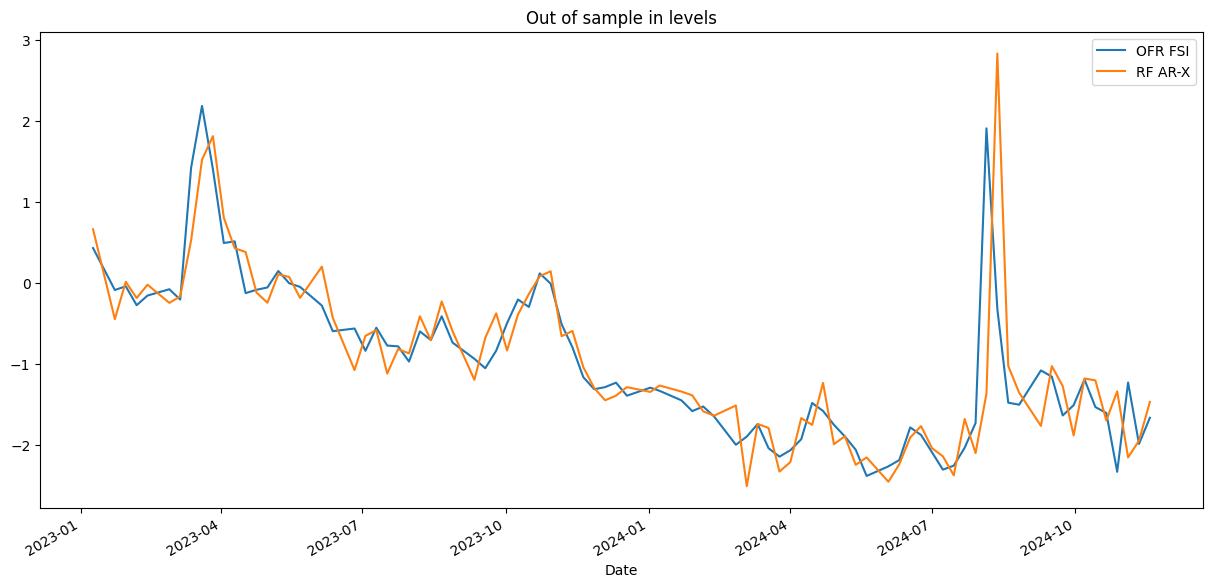

In [37]:
roll_levels[['OFR FSI','RF AR-X']].plot(figsize=(15,7), title="Out of sample in levels")

<Axes: title={'center': 'Out of sample in levels'}, xlabel='Date'>

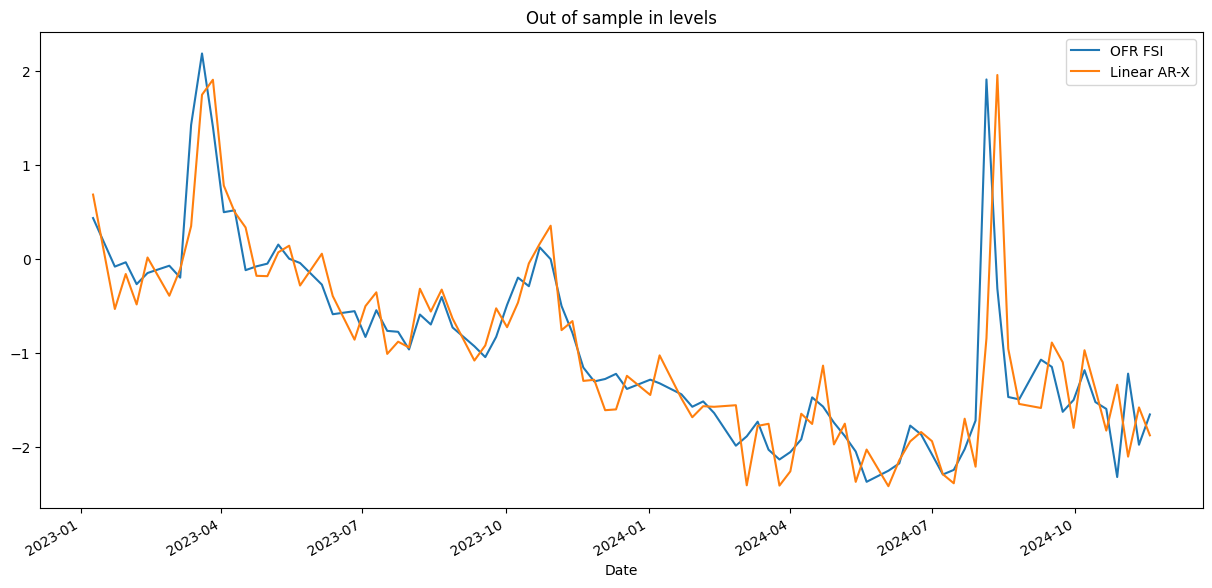

In [38]:
roll_levels[['OFR FSI','Linear AR-X']].plot(figsize=(15,7), title="Out of sample in levels")

## Conclusion:

1. Random Forrest with AR-X in a Rolling window saw slightly higher spikes than the OFR FSI.
2. Was able to model the FSI with 75% less data than the original (from 33 factors to 8)